# Objective

To illustrate monitoring checks using prediction logs.

# Setup

In [1]:
!pip install -q datasets==2.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind

In [46]:
sns.set_style('white')
sns.set_context('notebook')

# Access Logs

In [3]:
dataset = load_dataset("pgurazada1/machine-failure-logs")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
logs_df = dataset.data['train'].to_pandas()

In [5]:
logs_df.sample(5)

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
209                301.7                    310.2                    1686   
172                303.4                    311.5                    1560   
47                 296.9                    307.8                    1400   
103                300.6                    309.4                    1581   
249                300.0                    309.0                    1454   

     Torque [Nm]  Tool wear [min] Type  prediction  
209         28.9               59    L           0  
172         36.4              114    M           0  
47          57.1              202    L           0  
103         35.7              117    M           0  
249         51.7                2    L           0

# Access Training Data

In [6]:
dataset = fetch_openml(data_id=42890, as_frame=True, parser="auto")
data_df = dataset.data

target = 'Machine failure'
numeric_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
categorical_features = ['Type']

X = data_df[numeric_features + categorical_features]
y = data_df[target]

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Drift

The idea of drift is to check if there is a variation in live (production) data compared to the data that the model saw during training. Drift checks are conducted both on the features (data drift) and the targets (target drift).

## Model Drift

In [8]:
ytrain.value_counts()

Machine failure
0    7722
1     278
Name: count, dtype: int64

In [9]:
logs_df.prediction.value_counts()

prediction
0    247
1     18
Name: count, dtype: int64

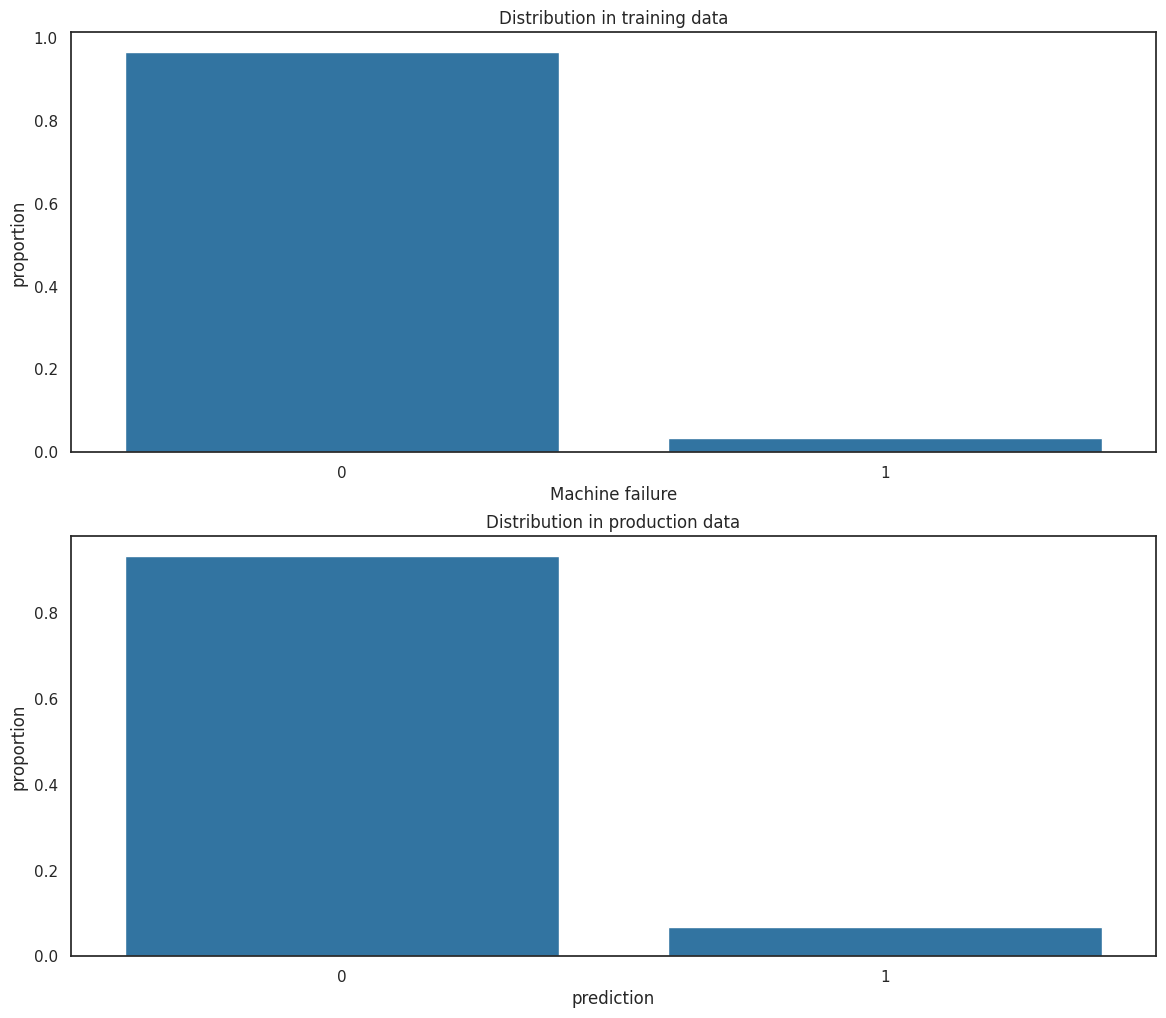

In [51]:
fig, axs = plt.subplots(2, figsize=(14, 12))

sns.countplot(
    pd.DataFrame(ytrain),
    x='Machine failure',
    stat='proportion',
    ax=axs[0]
).set_title('Distribution in training data')

sns.countplot(
    logs_df,
    x='prediction',
    stat='proportion',
    ax=axs[1]
).set_title('Distribution in production data')

plt.show()

In [10]:
p_reference = 278/ytrain.shape[0]
p_predictions = 18/logs_df.shape[0]

In [11]:
p_reference, p_predictions

(0.03475, 0.06792452830188679)

## Data Drift

We illustrate data drift checks using one feature - `Torque`.

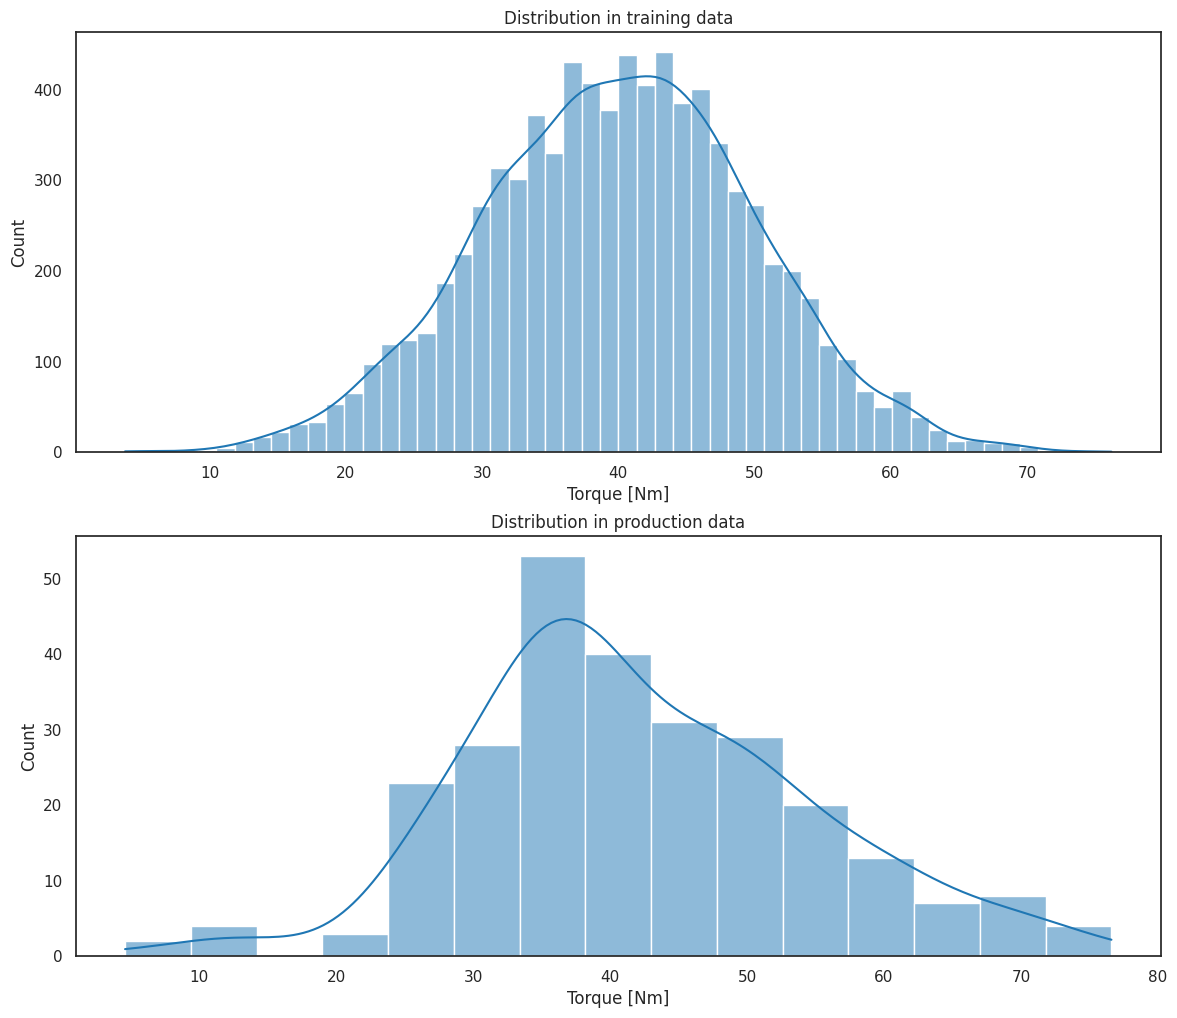

In [53]:
fig, axs = plt.subplots(2, figsize=(14, 12))

sns.histplot(
    Xtrain,
    x='Torque [Nm]',
    kde=True,
    ax=axs[0]
).set_title('Distribution in training data')

sns.histplot(
    logs_df,
    x='Torque [Nm]',
    kde=True,
    ax=axs[1]
).set_title('Distribution in production data')

plt.show()

In [35]:
ttest_ind(
    Xtrain['Torque [Nm]'],
    logs_df['Torque [Nm]']
)

TtestResult(statistic=-3.330300844334276, pvalue=0.0008713229935694878, df=8263.0)